###### ### The University of Melbourne, School of Computing and Information Systems
# COMP30027 Machine Learning, 2023 Semester 1

## Assignment 1: Music genre classification with naive Bayes


**Student ID(s):** `1079752`


This iPython notebook is a template which you will use for your Assignment 1 submission.

Marking will be applied on the four functions that are defined in this notebook, and to your responses to the questions at the end of this notebook (Submitted in a separate PDF file).

**NOTE: YOU SHOULD ADD YOUR RESULTS, DIAGRAMS AND IMAGES FROM YOUR OBSERVATIONS IN THIS FILE TO YOUR REPORT (the PDF file).**

You may change the prototypes of these functions, and you may write other functions, according to your requirements. We would appreciate it if the required functions were prominent/easy to find.

**Adding proper comments to your code is MANDATORY. **

In [2]:
import pandas as pd
import numpy as np
import scipy.stats
import math

In [3]:
train_set = pd.read_csv('pop_vs_classical_train.csv')
test_set = pd.read_csv('pop_vs_classical_test.csv')
train_gz = pd.read_csv('gztan_train.csv')
test_gz = pd.read_csv('gztan_test.csv')
eps = 1/(2*len(train_set)) # for epsilon smoothing

In [4]:
# This function should prepare the data by reading it from a file and converting it into a useful format for training and testing

def preprocess(data):
    # removes the column filename 
    # did not do any preprocessing that considered any non number values since the information sheet claims given data is clean
    
    data = data.drop('filename', axis=1, inplace=False)
    
        
    return data

In [5]:
train_set = preprocess(train_set)
test_set = preprocess(test_set)
test_gz = preprocess(test_gz)
train_gz = preprocess(train_gz)

In [6]:
# This function should calculate prior probabilities and likelihoods from the training data and using
# them to build a naive Bayes model

def train(data):
    # calculates the prior probability for each class and also calculates mean and sd for each feature given a class label
    # returns 2 dictionaries prior and mean_sd
    
    # calculating prior probabilities
    prior = dict() # prior[label] = prior probability
    labels = data['label']
    features = list(data.columns[:-1])
    
    unique_labels, counts = np.unique(labels, return_counts=True)
    n = counts.sum()
    
    for i in range(len(unique_labels)):
        prior[unique_labels[i]] = (counts[i] / n)
    
    # calculating mean and sd
    
    mean_sd = dict() # format is mean_sd[feature][class] = {'mean': mean, 'sd': sd}
    
    for feature in features:
        mean_sd[feature] = dict()
        for label in unique_labels:
            mean = data.loc[data['label'] == label, feature].mean()
            sd = data.loc[data['label'] == label, feature].std()
            mean_sd[feature][label] = {'mean': mean, 'sd': sd}
    
 
    return prior, mean_sd

In [7]:
def GaussNorm(mean,sd,x):
    # returns log(Norm) but this is what I used later on to do addition instead of multiplying to avoid underflow error
     return -np.log(sd*math.sqrt(2*np.pi))-(((x-mean)**2)/(2*sd**2))
    

In [8]:
# This function should predict classes for new items in a test dataset

def predict(test_set, train_set):
    # Predicts classes in test_set based on  training done on train_set using the train() func.
    # Returns a list of predictions
    
    prior, mean_sd = train(train_set) # This is the "training" part, which allows for easy use of the function rather than
                                      # having to call the train() function seperately.
    
    predictions = [] # Empty list for the predictions to be added
    
    features = list(test_set.columns[:-1])
    labels = np.unique(train_set['label'])
    
    
    # Iterates through each row and individual class label possible to test out all the possiblities and appends most likely to 
    # predictions, which is the returned list
    
    for idx, row in test_set.iterrows():
        post_probs = {}  
        
        for label in labels:
            prob = 0   
            
            for feature in features:
                prob += GaussNorm(mean_sd[feature][label]['mean'],mean_sd[feature][label]['sd'],row[feature]) 
                
            post_probs[label] = prob + np.log(prior[label])  
            
        predictions.append(max(post_probs, key=post_probs.get))
         
    return predictions

In [9]:
predictions = predict(test_set, train_set)

In [10]:
# This function should evaliate the prediction performance by comparing your model’s class outputs to ground
# truth labels

def evaluate(preds, truths):
    # Basic evaluation, correct guesses/total guesses
    
    total_preds = len(preds)
    true_preds = 0
    for i in range(len(preds)):
        if preds[i] == truths[i]:
            true_preds += 1
    
    
    return true_preds/total_preds

In [11]:
evaluate(predictions, list(test_set['label']))

0.9767441860465116

## Task 1. Pop vs. classical music classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q1
Compute and report the accuracy, precision, and recall of your model (treat "classical" as the "positive" class).

In [12]:

def eval2(preds, truths):
    # calculates accuracy, precision and recall of the predictions, returns as a dictionary to make it easier to make it 
    # easier to access it again in the future if needed - treated classical as positive class
    
    tp = 0 # True Positive
    tn = 0 # True Negative
    fp = 0 # False Positive
    fn = 0 # False Negative
    
    for i in range(len(preds)):
        if (preds[i] == truths[i]) and (preds[i] == 'classical'):
            tp += 1
        elif (preds[i] == truths[i]) and (preds[i] == 'pop'):
            tn += 1
        elif (preds[i] != truths[i]) and (preds[i] == 'classical'):
            fp += 1
        else:
            fn += 1
    
    accuracy = (tp+tn)/len(preds)
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    
    return {'accuracy': accuracy, 'precision' : precision, 
               'recall': recall}
    

In [13]:
eval2(predict(test_set, train_set), list(test_set['label']))

{'accuracy': 0.9767441860465116,
 'precision': 0.9523809523809523,
 'recall': 1.0}

### Q2
For each of the features X below, plot the probability density functions P(X|Class = pop) and P(X|Class = classical). If you had to classify pop vs. classical music using just one of these three features, which feature would you use and why? Refer to your plots to support your answer.
- spectral centroid mean
- harmony mean
- tempo

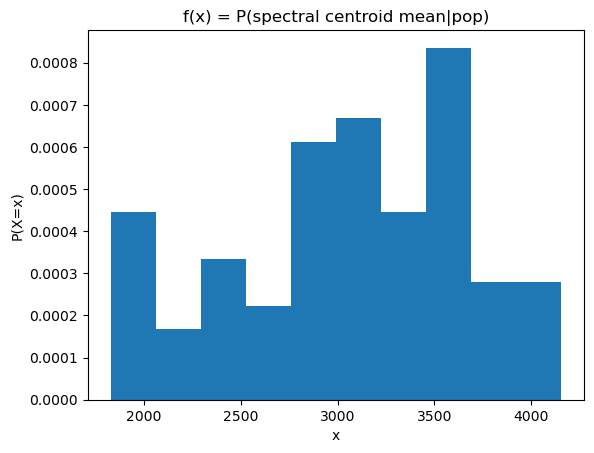

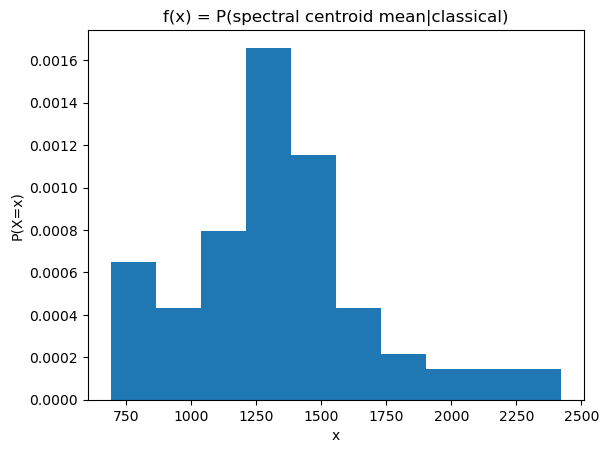

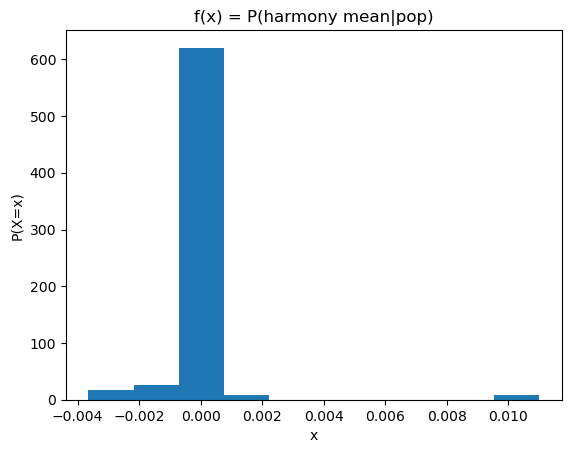

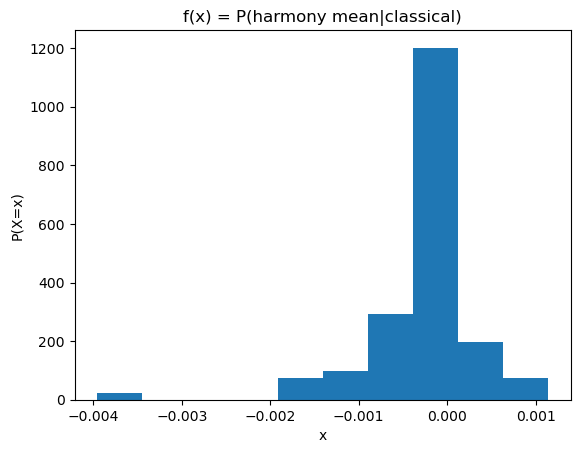

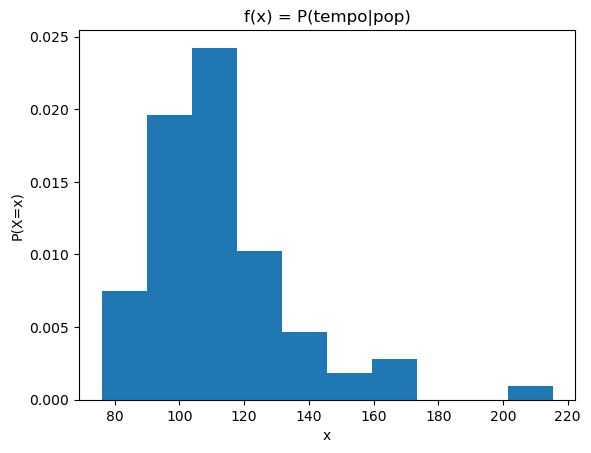

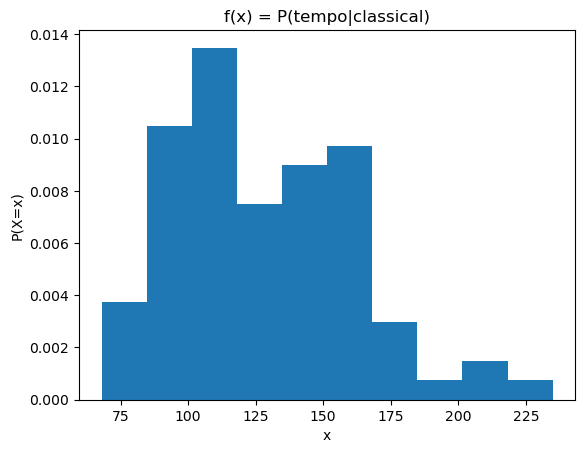

In [14]:
import matplotlib.pyplot as plt
norm = scipy.stats.norm
pdf = scipy.stats.uniform

train_set_3feats = train_set[['spectral_centroid_mean','harmony_mean', 'tempo','label']]


def plot_pdf(data):
    # plots P(X=x) for each feature and class label in data and prints them
    
    unique_classes = list(set(data['label']))
    
    for entry in data.columns[:-1]:
        for _class in unique_classes:
            x_axis = list([data.loc[data['label']==_class][entry]])
            
            graph = plt.hist(x_axis, density=True)
            str_entry = entry.replace('_', ' ')
            plt.title(f'f(x) = P({str_entry}|{_class})')
            plt.xlabel('x')
            plt.ylabel('P(X=x)')
            plt.show()

    return
    
    
plot_pdf(train_set_3feats)   

## Task 2. 10-way music genre classification

#### NOTE: you may develope codes or functions to help respond to the question here, but your formal answer must be submitted separately as a PDF.

### Q3
Compare the performance of the full model to a 0R baseline and a one-attribute baseline. The one-attribute baseline should be the best possible naive Bayes model which uses only a prior and a single attribute. In your write-up, explain how you implemented the 0R and one-attribute baselines.

### Q4
Train and test your model with a range of training set sizes by setting up your own train/test splits. With each split, use cross-fold validation so you can report the performance on the entire dataset (1000 items). You may use built-in functions to set up cross-validation splits. In your write-up, evaluate how model performance changes with training set size.

### Q5
Implement a kernel density estimate (KDE) naive Bayes model and compare its performance to your Gaussian naive Bayes model. You may use built-in functions and automatic ("rule of thumb") bandwidth selectors to compute the KDE probabilities, but you should implement the naive Bayes logic yourself. You should give the parameters of the KDE implementation (namely, what bandwidth(s) you used and how they were chosen) in your write-up.

### Q6
Modify your naive Bayes model to handle missing attributes in the test data. Recall from lecture that you can handle missing attributes at test by skipping the missing attributes and computing the posterior probability from the non-missing attributes. Randomly delete some attributes from the provided test set to test how robust your model is to missing data. In your write-up, evaluate how your model's performance changes as the amount of missing data increases.

In [15]:
# This cell was taken from https://stackoverflow.com/questions/68478052/how-to-randomly-delete-10-of-attributes-values-from-a-pandas-dataframe

import numpy as np

def delete_random(data, vol):
    # Deletes random entries from pandas dataframe and saves new dataframe as a seperate one
    
    new_data = data.drop('label', axis=1, inplace=False)
    
    # get dimensions of df
    nrows, ncols = len(new_data.index), len(new_data.columns)       

    volume = nrows * ncols                    # total number of entries in df
    volume_to_be_nan = int(volume * vol)      # number of entries to turn to NaN

    # randomly generate index locations for the new NaNs
    indices = np.random.permutation(range(volume)[:volume_to_be_nan])
    row_indices = indices % nrows
    col_indices = (indices / nrows).astype(int)

    # assign NaN to each of the indices in df
    for ri, ci in zip(row_indices, col_indices):
        new_data.iloc[ri, ci] = None
    return new_data

In [16]:
def predict_2(test_data, train_data):
    # Predicts classes based on trained set and returns a list of predictions
    # modified to handle missing attributes in test data
    
    prior, mean_sd = train(train_data)
    
    predicted = []
    features = list(test_data.columns[:-1])
    labels = np.unique(train_data['label'])
    
    predictions = []
    for idx, row in test_data.iterrows():
        post_probs = {}
        for label in labels:
            prob = 0
            for feature in features:
                if pd.isna(row[feature]):
                    continue                   
                prob += GaussNorm(mean_sd[feature][label]['mean'],mean_sd[feature][label]['sd'],row[feature])
            post_probs[label] = prob + np.log(prior[label])
            
        predictions.append(max(post_probs, key=post_probs.get))
      
        
    
    return predictions



In [27]:
deleted_test = delete_random(test_gz, 0.3)
predictions = predict_2(deleted_test, train_gz)

evaluate(predictions, list(test_gz['label']))

0.475